In [51]:
!pip install yfinance -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [67]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, Add, Average, Multiply, Concatenate, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import initializers

In [68]:
df = yf.download('SPY', progress=False)

In [69]:
def preprocess(df):
    # Calculate RSI
    def calc_rsi(close, period):
        deltas = close.diff()
        gains = deltas.clip(lower=0)
        losses = -deltas.clip(upper=0)
        avg_gain = gains.rolling(window=period, min_periods=1).mean()
        avg_loss = losses.rolling(window=period, min_periods=1).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (rs + 1))
        return rsi

    # Calculate OBV
    def calc_obv(df):
        obv = ((df['Close'] > df['Close'].shift(1)) * 2 - 1) * df['Volume']
        return obv.cumsum()

    # Calculate MACD
    def calc_macd(df):
        ema12 = df['Close'].ewm(span=12, adjust=False).mean()
        ema26 = df['Close'].ewm(span=26, adjust=False).mean()
        macd = ema12 - ema26
        macd_signal = macd.ewm(span=9, adjust=False).mean()
        macd_histogram = macd - macd_signal
        return macd, macd_signal, macd_histogram

    # Calculate ATR
    def calculate_atr(df, period=3):
        high_low = df['High'] - df['Low']
        high_previous_close = np.abs(df['High'] - df['Close'].shift(1))
        low_previous_close = np.abs(df['Low'] - df['Close'].shift(1))
        true_range = pd.DataFrame({
            'High-Low': high_low, 
            'High-PreviousClose': high_previous_close, 
            'Low-PreviousClose': low_previous_close
        })
        tr = true_range.max(axis=1)
        atr = tr.rolling(window=period, min_periods=1).mean()
        return atr

    # Add technical indicators
    def add_technicals(df):
        df['MA5'] = df['Close'].rolling(5).mean()
        df['MA10'] = df['Close'].rolling(10).mean()
        df['RSI'] = calc_rsi(df['Close'], period=14)
        df['OBV'] = calc_obv(df)
        df['MACD'], df['MACD Signal'], df['MACD Histogram'] = calc_macd(df)
        df['ATR'] = calculate_atr(df)
        df['MA_Cross'] = (df['MA5'] > df['MA10']).astype(int)
        return df

    # Remove 'Adj Close' if present
    df = add_technicals(df)
    df = df.drop(columns=['Adj Close', 'Volume'], errors='ignore')

    # Create Target columns for the next day's prices
    df['Target1'] = df['Close'].shift(-1)
    #df['Target2'] = df['Close'].shift(-2)
    #df['Target3'] = df['Close'].shift(-3)

    return df.dropna()

df = preprocess(df)

In [70]:
# Scale the features and target
scalers = {}
target_columns = ['Target1']#, 'Target2', 'Target3']
feature_columns = list(df.columns)
for i in target_columns:
    feature_columns.remove(i)
print(feature_columns)
for col in feature_columns:
    scaler = StandardScaler()
    df[col] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler

# Scale the target column separately
target_scaler = StandardScaler()
df['Target1'] = target_scaler.fit_transform(df[['Target1']])
scalers['Target1'] = target_scaler
"""target_scaler = StandardScaler()
df['Target2'] = target_scaler.fit_transform(df[['Target2']])
scalers['Target2'] = target_scaler
target_scaler = StandardScaler()
df['Target3'] = target_scaler.fit_transform(df[['Target3']])
scalers['Target3'] = target_scaler"""

['Open', 'High', 'Low', 'Close', 'MA5', 'MA10', 'RSI', 'OBV', 'MACD', 'MACD Signal', 'MACD Histogram', 'ATR', 'MA_Cross']


"target_scaler = StandardScaler()\ndf['Target2'] = target_scaler.fit_transform(df[['Target2']])\nscalers['Target2'] = target_scaler\ntarget_scaler = StandardScaler()\ndf['Target3'] = target_scaler.fit_transform(df[['Target3']])\nscalers['Target3'] = target_scaler"

In [71]:
def sequencer(df, sl):
    xs, ys = [], []
    num_rows = len(df)
    for i in range(0, num_rows - sl + 1):
        chunk = df.iloc[i:i + sl]
        nchunk = df.iloc[i+1:i+sl+1]
        features = chunk.drop(target_columns, axis=1).values
        target = nchunk[target_columns].values[0]
        xs.append(features)
        ys.append(target)
    return np.array(xs), np.array(ys)

# Create sequences
sequence_length = 15
X_sequences, y_sequences = sequencer(df, sequence_length)

print(f'X_sequences shape: {X_sequences.shape}')
print(f'y_sequences shape: {y_sequences.shape}')

X_sequences shape: (7922, 15, 13)
y_sequences shape: (7922, 1)


In [72]:
# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [93]:
def build_model():
    inputs = Input(shape=(sequence_length, len(feature_columns)))
    x = LSTM(512, kernel_regularizer=regularizers.L2(1e-4))(inputs)
    y = GRU(512, kernel_regularizer=regularizers.L2(1e-4))(inputs)
    merge = Average()([x, y])
    z = Dropout(.1)(merge)
    outputs = Dense(1, activation='linear', kernel_regularizer=regularizers.L2(1e-4))(z)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.006, momentum=.9), loss='mse', metrics=['mape'])
    return model

In [94]:
model = build_model()

In [95]:
mcb = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_mape', mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=100, min_delta=1e-5),
]
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=1000,
    batch_size=8,
    callbacks=mcb,
    shuffle=True,
)

Epoch 1/1000
793/793 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0390 - mape: 17.0703 - val_loss: 0.0057 - val_mape: 4.4162
Epoch 2/1000
793/793 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0068 - mape: 5.7188 - val_loss: 0.0056 - val_mape: 3.4633
Epoch 3/1000
793/793 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0063 - mape: 5.7634 - val_loss: 0.0056 - val_mape: 3.6351
Epoch 4/1000
793/793 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0061 - mape: 5.0857 - val_loss: 0.0053 - val_mape: 3.3058
Epoch 5/1000
793/793 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0059 - mape: 5.1437 - val_loss: 0.0052 - val_mape: 3.2233
Epoch 6/1000
793/793 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0057 - mape: 4.8565 - val_loss: 0.0053 - val_mape: 3.5892
Epoch 7/1000
793/793 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0056 - mape: 4.0853 - val_loss: 0.0052 - val_mape: 3.2799
Epoch 8/1000
793/793 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0055 - mape: 4.0630 - val_loss: 0.0048 - val_mape: 3.2770
Epoch 9/1000
793/793 ━━

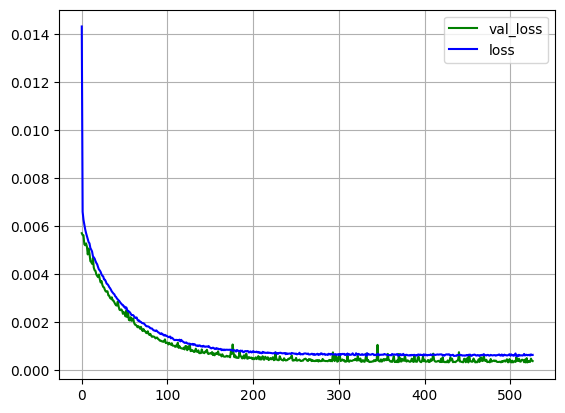

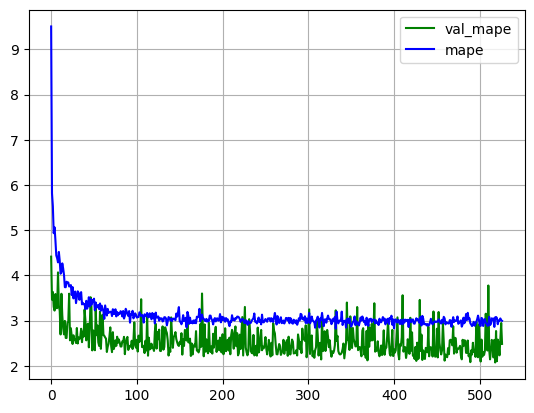

In [96]:
# Plot training & validation loss
plt.plot(history.history['val_loss'], color='green', label='val_loss')
plt.plot(history.history['loss'], color='blue', label='loss')
plt.grid()
plt.legend()
plt.show()

# Plot training & validation MAPE
plt.plot(history.history['val_mape'], color='green', label='val_mape')
plt.plot(history.history['mape'], color='blue', label='mape')
plt.grid()
plt.legend()
plt.show()

In [97]:
import keras
model = keras.saving.load_model('best_model.keras')

In [98]:
model.evaluate(X_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5172e-04 - mape: 2.0138 


[0.00039036761154420674, 1.9457908868789673]